# **Credit Default** - Simple Models

Source:  [https://github.com/d-insight/code-bank.git](https://github.com/d-insight/code-bank.git)  
License: [MIT License](https://opensource.org/licenses/MIT). See open source [license](LICENSE) in the Code Bank repository. 

-------------

## Overview

In this demo, we try to predict the probability of default on credit card bills using a dataset of customers payments from a Taiwanese bank. A credit default happens when you fail to pay the minimum payment by the due date mentioned on your credit card bill for more than 6 months. From a risk management perspective, the accuracy of the predicted probability of default is more valuable than just a binary prediction (classification) of default itself.

<img src="https://greendayonline.com/wp-content/uploads/2017/03/Recovering-From-Student-Loan-Default.jpg" width="500" height="500" align="center"/>


Image: https://greendayonline.com/wp-content/uploads/2017/03/Recovering-From-Student-Loan-Default.jpg

#### The Credit Card Default Dataset 

We will try to predict the probability of defaulting on a credit card account at a Taiwanese bank. A credit card default happens when a customer fails to pay the minimum due on a credit card bill for more than 6 months. 

We will use a dataset from a Taiwanese bank with 30,000 observations (Source: *Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.*). Each observation represents an account at the bank at the end of October 2005.  We renamed the variable default_payment_next_month to customer_default. The target variable to predict is `customer_default` -- i.e., whether the customer will default in the following month (1 = Yes or 0 = No). The dataset also includes 23 other explanatory features. 

Variables are defined as follows:

| Feature name     | Variable Type | Description 
|------------------|---------------|--------------------------------------------------------
| customer_default | Binary        | 1 = default in following month; 0 = no default 
| LIMIT_BAL        | Continuous    | Credit limit   
| SEX              | Categorical   | 1 = male; 2 = female
| EDUCATION        | Categorical   | 1 = graduate school; 2 = university; 3 = high school; 4 = others
| MARRIAGE         | Categorical   | 0 = unknown; 1 = married; 2 = single; 3 = others
| AGE              | Continuous    | Age in years  
| PAY1             | Categorical   | Repayment status in September, 2005 
| PAY2             | Categorical   | Repayment status in August, 2005 
| PAY3             | Categorical   | Repayment status in July, 2005 
| PAY4             | Categorical   | Repayment status in June, 2005 
| PAY5             | Categorical   | Repayment status in May, 2005 
| PAY6             | Categorical   | Repayment status in April, 2005 
| BILL_AMT1        | Continuous    | Balance in September, 2005  
| BILL_AMT2        | Continuous    | Balance in August, 2005  
| BILL_AMT3        | Continuous    | Balance in July, 2005  
| BILL_AMT4        | Continuous    | Balance in June, 2005 
| BILL_AMT5        | Continuous    | Balance in May, 2005  
| BILL_AMT6        | Continuous    | Balance in April, 2005  
| PAY_AMT1         | Continuous    | Amount paid in September, 2005
| PAY_AMT2         | Continuous    | Amount paid in August, 2005
| PAY_AMT3         | Continuous    | Amount paid in July, 2005
| PAY_AMT4         | Continuous    | Amount paid in June, 2005
| PAY_AMT5         | Continuous    | Amount paid in May, 2005
| PAY_AMT6         | Continuous    | Amount paid in April, 2005

The measurement scale for repayment status is:   

    -2 = payment two months in advance   
    -1 = payment one month in advance   
    0 = pay duly   
    1 = payment delay for one month   
    2 = payment delay for two months   
    3 = payment delay for three months   
    4 = payment delay for four months   
    5 = payment delay for five months   
    6 = payment delay for six months   
    7 = payment delay for seven months   
    8 = payment delay for eight months   
    9 = payment delay for nine months or more  

-------

## **Part 0**: Setup

Put all import statements, constants and helper functions at the top of your notebook.

In [1]:
# Standard imports
import numpy  as np
import pandas as pd
import pandas_profiling
import itertools

# Visualization packages 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from sklearn.metrics         import confusion_matrix, roc_auc_score
from sklearn.linear_model    import LogisticRegression
from sklearn.dummy           import DummyClassifier
from sklearn.model_selection import train_test_split

# Special code to ignore un-important warnings 
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline  

In [2]:
# Constants 
FIGSIZE = (10, 6)

In [3]:
# Define a helper function to visualize the confusion matrix
# Note optional parameter for normalization; apply normalization by setting `normalize=True`

def plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion Matrix', cmap=plt.cm.Reds):
    """ 
    Function to plot a sklearn confusion matrix, showing number of cases per prediction condition 
    
    Args:
        cm         an sklearn confusion matrix
        classes    levels of the class being predicted; default to binary outcome
        normalize  apply normalization by setting `normalize=True`
        title      title for the plot
        cmap       color map
    """
    
    plt.figure(figsize=FIGSIZE)
    plt.imshow(cm, aspect='auto', interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.locator_params(nbins=2)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max() / 2.
    
    # add FP, TP, FN, TN counts
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round (cm[i, j],2), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 12)
        
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

## **Part 1**: Data Preprocessing and EDA

First, we would like to understand the main characteristics of the dataset. We might need to transform and clean some features before we can specify a statistical model.

In [4]:
# Load data into a dataframe
data = pd.read_csv('credit_data.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,customer_default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
# Print data columns
data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'customer_default'],
      dtype='object')

In [6]:
# Dimension of data in the form of (number of observations, number of features)
data.shape

(30000, 25)

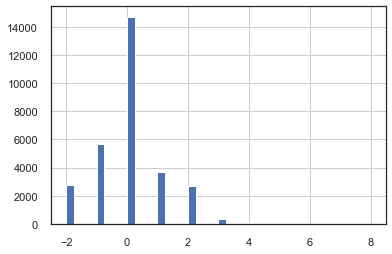

In [7]:
# Check distribution of an arbitrary column
data['PAY_1'].hist(bins=40)

In [8]:
# Another way to check distribution of value
data['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [9]:
# Get ovrall statistics about data frame
data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,customer_default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [10]:
# Investigate 'EDUCATION' field 
# Notice the mismatch between data description and actual data !
data['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [11]:
# Cross-tab 'MARRIAGE' and the target 
pd.crosstab(data['MARRIAGE'], data['customer_default'], margins = True)

customer_default,0,1,All
MARRIAGE,,,
0,49,5,54
1,10453,3206,13659
2,12623,3341,15964
3,239,84,323
All,23364,6636,30000


In [12]:
# Check data types
data.dtypes

ID                  int64
LIMIT_BAL           int64
SEX                 int64
EDUCATION           int64
MARRIAGE            int64
AGE                 int64
PAY_1               int64
PAY_2               int64
PAY_3               int64
PAY_4               int64
PAY_5               int64
PAY_6               int64
BILL_AMT1           int64
BILL_AMT2           int64
BILL_AMT3           int64
BILL_AMT4           int64
BILL_AMT5           int64
BILL_AMT6           int64
PAY_AMT1            int64
PAY_AMT2            int64
PAY_AMT3            int64
PAY_AMT4            int64
PAY_AMT5            int64
PAY_AMT6            int64
customer_default    int64
dtype: object

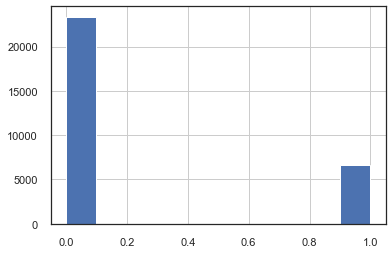

In [13]:
# Check distribution of target feature
data['customer_default'].hist()

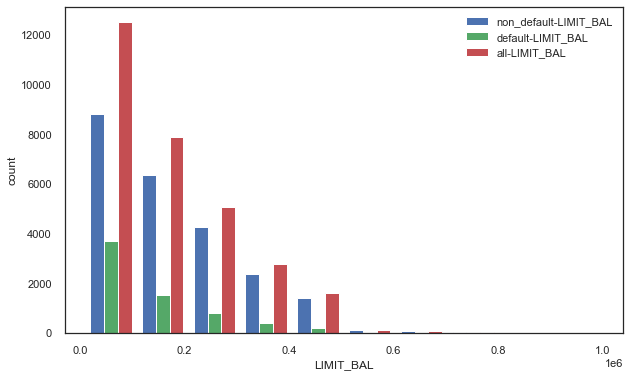

In [14]:
# Divide dataframe into two data frames, with and without credit default
data_def_1 = data[data['customer_default'] == 1]
data_def_0 = data[data['customer_default'] == 0]

# Check distribution of different features in with and without default dataframes as well as full dataframe
plt.figure(figsize=FIGSIZE)
plt.style.use('seaborn-deep')
col = 'LIMIT_BAL'
plt.xlabel(col)
plt.ylabel('count')
plt.hist([data_def_0[col], data_def_1[col], data[col]], label=['non_default-'+col, 'default-'+col, 'all-'+col])
plt.legend(loc='upper right')
plt.show()

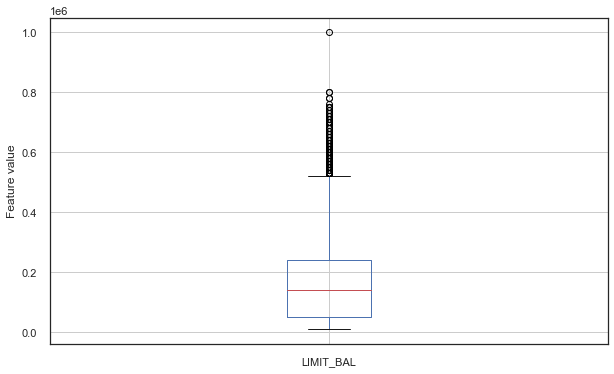

In [15]:
# Check distribution of different features using box plot. How are the box and whisker positions defined? Click Shift + Tab
plt.figure(figsize=FIGSIZE)
data.boxplot(column='LIMIT_BAL')
plt.ylabel('Feature value')
plt.show()

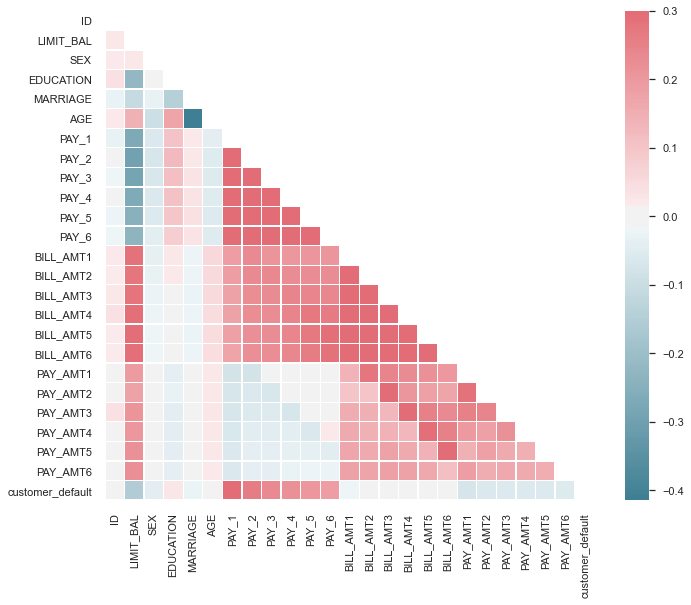

In [16]:
# Visualize corelation of different features with respect to each other

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Setup the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.2)

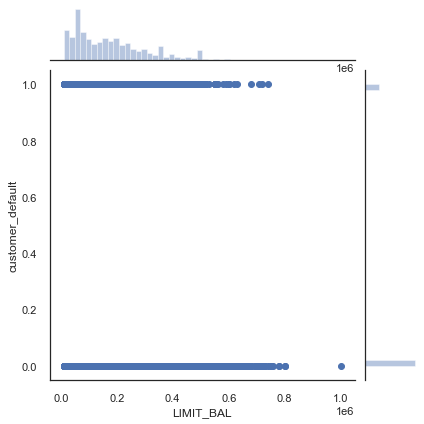

In [17]:
# Visualize distribution of one feature with respect to another one
sns.jointplot(x = "LIMIT_BAL", y = "customer_default", data = data)

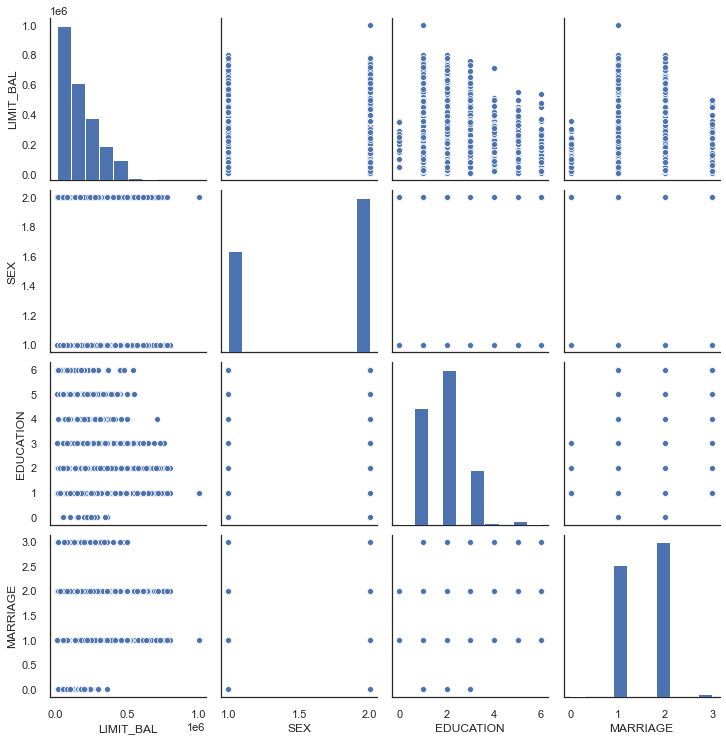

In [18]:
# Visualize pair-wise distribution of a set of features
sample_data = data.iloc[:,1:5]
sns.pairplot(sample_data)

### Exploratory Data Analysis (the automated approach)

Instead of performing all of the steps above manually, you can also run a "profile" on the dataset first, and then drill down into specific cases of interest.

In [19]:
# Use the automated pandas profiling utility to examine the dataset
# data.profile_report()

## **Part 2**: Data Preprocessing and Designing Cross-validation Schema

Among different features, SEX and MARRIAGE are categoical while others are either numerical or ordinal with acceptable labeling.

In [20]:
# One hot encoding of sex and marital status
# Applying one-hot encoding for other field doesn't make sense since they are either numeric or ordinal
cols_to_transform = ['SEX', 'MARRIAGE']
data_with_dummies = pd.get_dummies(data=data, columns = cols_to_transform)

In [21]:
data_with_dummies.head()

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,customer_default,SEX_1,SEX_2,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,1,20000,2,24,2,2,-1,-1,-2,-2,...,0,0,0,1,0,1,0,1,0,0
1,2,120000,2,26,-1,2,0,0,0,2,...,1000,0,2000,1,0,1,0,0,1,0
2,3,90000,2,34,0,0,0,0,0,0,...,1000,1000,5000,0,0,1,0,0,1,0
3,4,50000,2,37,0,0,0,0,0,0,...,1100,1069,1000,0,0,1,0,1,0,0
4,5,50000,2,57,-1,0,-1,0,0,0,...,9000,689,679,0,1,0,0,1,0,0


In [22]:
# Separate features and target
cols_X = [ 'LIMIT_BAL', 'EDUCATION', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3',
           'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
           'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
           'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'SEX_2', 'MARRIAGE_0',
           'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3']
col_y  =   'customer_default'

X = data_with_dummies.loc[:, cols_X]
y = data_with_dummies[col_y]

In [23]:
# Divide data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [24]:
print(X_train.shape , X_test.shape , y_train.shape , y_test.shape)

(24000, 27) (6000, 27) (24000,) (6000,)


## **Part 3**: Classification using Dummy Classifier and Logistic Regression

### Model 1: Baseline

A good practice is to start with a "dumb" model that simply predicts the average (for a regression) or the most frequent outcome (for classification). That gives you sense of how well a complex model performs compared to the most simple model. As this is a classification problem, we will start by predicting No Default.

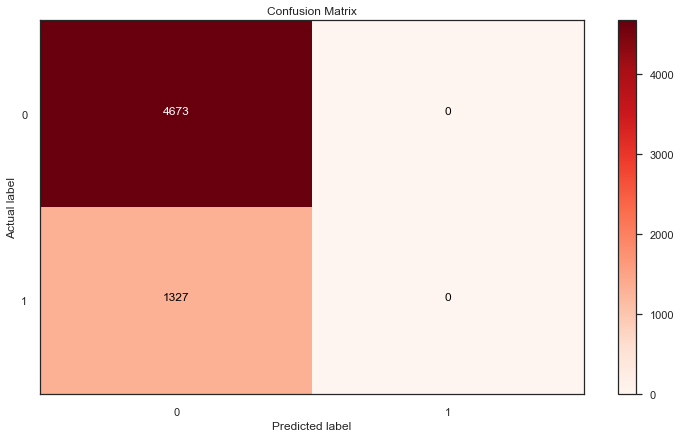

In [25]:
# Define a baseline using dummy classifier that predicts the most frequent label
dummy_clf = DummyClassifier(strategy = 'most_frequent')
dummy_clf.fit(X_train, y_train)

# Predict default - as a binary outcome and a probability between 0 and 1
y_pred_dummy       = dummy_clf.predict(X_test)
y_pred_dummy_proba = dummy_clf.predict_proba(X_test)

# Plot confusion matrix
cm_dummy = confusion_matrix(y_test, y_pred_dummy)
plot_confusion_matrix(cm_dummy)

In [26]:
# How many errors did the dumb model make?
errors_dummy  = cm_dummy[0][1] + cm_dummy[1][0]
correct_dummy = cm_dummy[0][0] + cm_dummy[1][1]

print('Num Errors =', errors_dummy, '\n')
print('Accuracy   =', "{0:.4f}".format(float(correct_dummy)/len(y_test)))
print('AUC Score  =', "{0:.4f}".format(roc_auc_score(y_test, y_pred_dummy_proba[:, 1])))

Num Errors = 1327 

Accuracy   = 0.7788
AUC Score  = 0.5000


### Model 2: Logit model (no regularization)

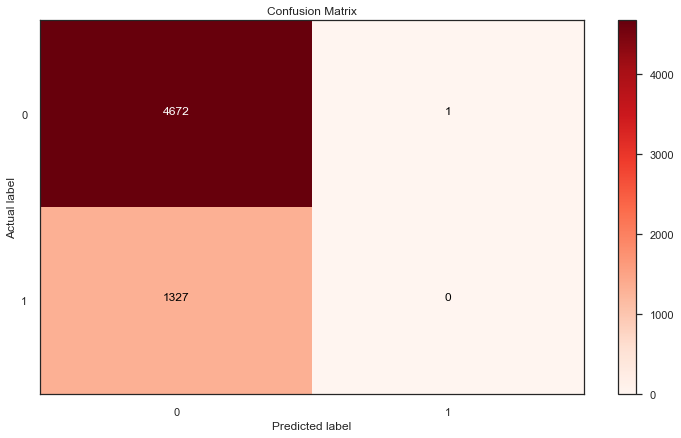

In [27]:
# Binary classification using a logit model
lr_clf = LogisticRegression(C = 10e9)
lr_clf.fit(X_train, y_train)

# Predict default - as a binary outcome and a probability between 0 and 1
y_pred_lr       = lr_clf.predict(X_test)
y_pred_lr_proba = lr_clf.predict_proba(X_test)

# Plot confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cm_lr,)

In [28]:
# How many errors did the dumb model make?
errors_lr = cm_lr[0][1] + cm_lr[1][0]
correct_lr = cm_dummy[0][0] + cm_dummy[1][1]

print('Num Errors =', errors_lr, '\n')
print('Accuracy   =', "{0:.4f}".format(float(correct_lr)/len(y_test)))
print('AUC Score  =', "{0:.4f}".format(roc_auc_score(y_test, y_pred_lr_proba[:, 1])))

Num Errors = 1328 

Accuracy   = 0.7788
AUC Score  = 0.6491


## **Summary of performance metrics**

### Accuracy

In [29]:
width = 30
models = ['Dummy', 'Logit']
results = [float((sum(cm_dummy)[0] - errors_dummy)/sum(cm_dummy)[0]), float((sum(cm_lr)[0] - errors_lr)/sum(cm_lr)[0])]
print('', '=' * width, '\n', 'Summary of Accuracy Scores'.center(width), '\n', '=' * width)  
for i in range(len(models)):
    print(models[i].center(width-8), '{0:.4f}'.format(results[i]))

   Summary of Accuracy Scores   
        Dummy          0.7788
        Logit          0.7786


### AUC 

In [30]:
width = 25
models = ['Dummy', 'Logit']
results = [roc_auc_score(y_test, y_pred_dummy_proba[:, 1]), roc_auc_score(y_test, y_pred_lr_proba[:, 1])]
print('', '=' * width, '\n', 'Summary of AUC Scores'.center(width), '\n', '=' * width)  
for i in range(len(models)):
    print(models[i].center(width-8), '{0:.4f}'.format(results[i]))

   Summary of AUC Scores   
      Dummy       0.5000
      Logit       0.6491


## **Part 4**: Discussion

**Accuracy?**

Note that the logit model did WORSE than the baseline model above (at least when predicting class labels with a default probability threshold and when evaluated by the total number of errors made by the model). Using accuracy to compare models, however, as two drawbacks for this credit default problem:  

  1. The distribution of the target outcome variable is not balanced. Therefore, a model that uniformly predicts that NO customer will default can still get a high accuracy.

  2. Different probability thresholds for making a "positive" prediction can lead to different performance results in the model. Thus, it may be more sensible to configure the model to predict and use probabilities, instead of directly predicting a label.  

A more useful metric for classification is the "**Area under the ROC curve**" (also called the **AUC**). The AUC gives you the probability that a randomly selected customer that is labeled as defaulting will be assigned a higher probability of default than a randomly selected customer that is labeled as NOT defaulting. The AUC also does not suffer from class skewness, and therefore is able to adjust for probabilities directly (instead of the distribution of class labels). But looking above, how do AUC scores actually compare...?  

**Do we need to standardize the data?**   

It is not necessary to normalize or standardize data for linear models when there is no regularization or special optimization procedure involved. Estimated coefficients will adjust to non-normalized data and the accuracy of the prediction will not be affected. 

**Was our training/testing method robust?** 

One concern with the previous training/testing approach is that the relative performance of the baseline model and the Logit model might depend on the particular training/testing split in the data that was performed. In a more advanced analysis, we might use k-fold cross-validation for a more reliable testing estimate. Another concern with the previous training/testing approach arises when we need to "tune" a model with a hyper-parameter for better performance. In that case, hyper-parameter tuning would pick up information from the testing data and overfit the model. In the models that follow, we will need to tune hyper-parameters, so we will now need to change our testing strategy and generate three data splits: **training** (60%), **validation** (20%) and **test** (20%). We can do this by first splitting a training/testing set 80/20, and then further split the training set into a smaller training set and a validation set. The terminology for these sets can be confusing (and different resources use different names for the sets), but in this example we will create a "Validation Set" that pulls from what was originally part of the training set. Most importantly, one should set aside a testing set that is *never used* until the very final test.